In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
df1 = pd.read_excel('Modelo_Excel.xlsx', sheet_name='Grado x')
df2 = pd.read_excel('Modelo_Excel.xlsx', sheet_name='Grado xx')

nombres_cursos = df1.columns.tolist()

In [ ]:
print(nombres_cursos)

##Visualizacion de Datos

In [62]:
df1

,Curso A,Curso B,Curso C,Curso D,Curso E,Curso F
0,14,12,13,20,12,14
1,12,13,13,20,14,14


In [63]:
df2

,Curso A,Curso B,Curso C,Curso D,Curso E,Curso F
0,15,15,20,12,12,12
1,14,15,20,15,14,14


##Preprocesamiento de datos

In [64]:
df1.isnull()

,Curso A,Curso B,Curso C,Curso D,Curso E,Curso F
0,False,False,False,False,False,False
1,False,False,False,False,False,False


In [65]:
df2.isnull()

,Curso A,Curso B,Curso C,Curso D,Curso E,Curso F
0,False,False,False,False,False,False
1,False,False,False,False,False,False


In [66]:
df1.isnull().sum()

Curso A    0
Curso B    0
Curso C    0
Curso D    0
Curso E    0
Curso F    0
dtype: int64

In [67]:
df2.isnull().sum()

Curso A    0
Curso B    0
Curso C    0
Curso D    0
Curso E    0
Curso F    0
dtype: int64

In [68]:
df1.fillna(0, inplace=True)
df1 = df1.apply(pd.to_numeric, errors='coerce')
df1.fillna(0, inplace=True)

In [69]:
df2.fillna(0, inplace=True)
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2.fillna(0, inplace=True)

##Construcción del Modelo

In [70]:
x = df1[nombres_cursos].values
y = df2[nombres_cursos].values

In [71]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(6,)),  # Capa de entrada con 9 neuronas de entrada (notas cursos anteriores)
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6)  # Capa de salida con 9 neuronas (notas cursos siguientes)
])

In [73]:
model.compile(optimizer='adam', loss='mse')

##Entrenamiento del Modelo

In [74]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [75]:
model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0, callbacks=[early_stopping])

In [76]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Pérdida en el conjunto de prueba: {loss}")

Pérdida en el conjunto de prueba: 27.55274772644043


##Prueba de Predicción

In [77]:
test_data = pd.read_excel('Modelo_Excel.xlsx')

caracteristicas_prediccion = test_data.values

predicciones = model.predict(caracteristicas_prediccion)
df_predicciones = pd.DataFrame(predicciones, columns=nombres_cursos)
print("Predicciones:")
print(df_predicciones)

1/1 [==============================] - 0s 50ms/step
Predicciones:
     Curso A    Curso B    Curso C    Curso D    Curso E   Curso F
0  20.279976  20.651735  12.342989  13.328769  11.810884  8.597244
1  19.247944  19.654068  11.765476  12.605897  11.115941  8.146935


In [82]:
model.save('my_model.h5')

['model.pkl']

In [78]:
def clasificar_notas(nota):
    if nota <= 10:
        return 'Necesita mejorar significativamente'
    elif nota <= 14:
        return 'Necesita mejorar'
    elif nota <= 18:
        return 'Tiene un buen rendimiento'
    else:
        return 'Tiene un excelente rendimiento'

df_predicciones_categorias = df_predicciones.applymap(clasificar_notas)

print("Predicciones:")
print(df_predicciones_categorias)

Predicciones:
                          Curso A                         Curso B  \
0  Tiene un excelente rendimiento  Tiene un excelente rendimiento   
1  Tiene un excelente rendimiento  Tiene un excelente rendimiento   

            Curso C           Curso D           Curso E  \
0  Necesita mejorar  Necesita mejorar  Necesita mejorar   
1  Necesita mejorar  Necesita mejorar  Necesita mejorar   

                               Curso F  
0  Necesita mejorar significativamente  
1  Necesita mejorar significativamente  


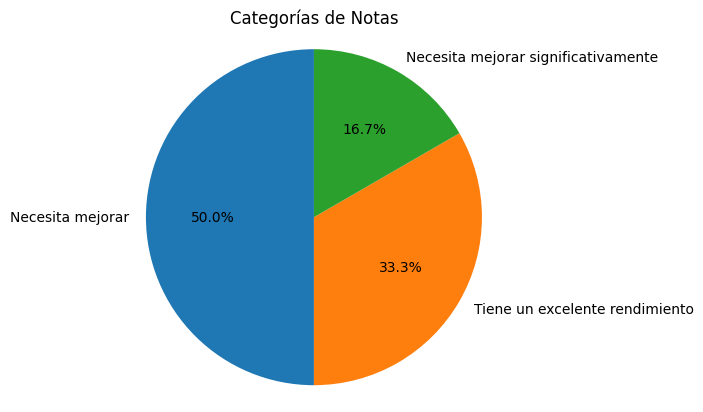

In [79]:
categorias = df_predicciones_categorias.stack().value_counts()

fig, ax = plt.subplots()
ax.pie(categorias, labels=categorias.index, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
plt.title('Categorías de Notas')
plt.show()

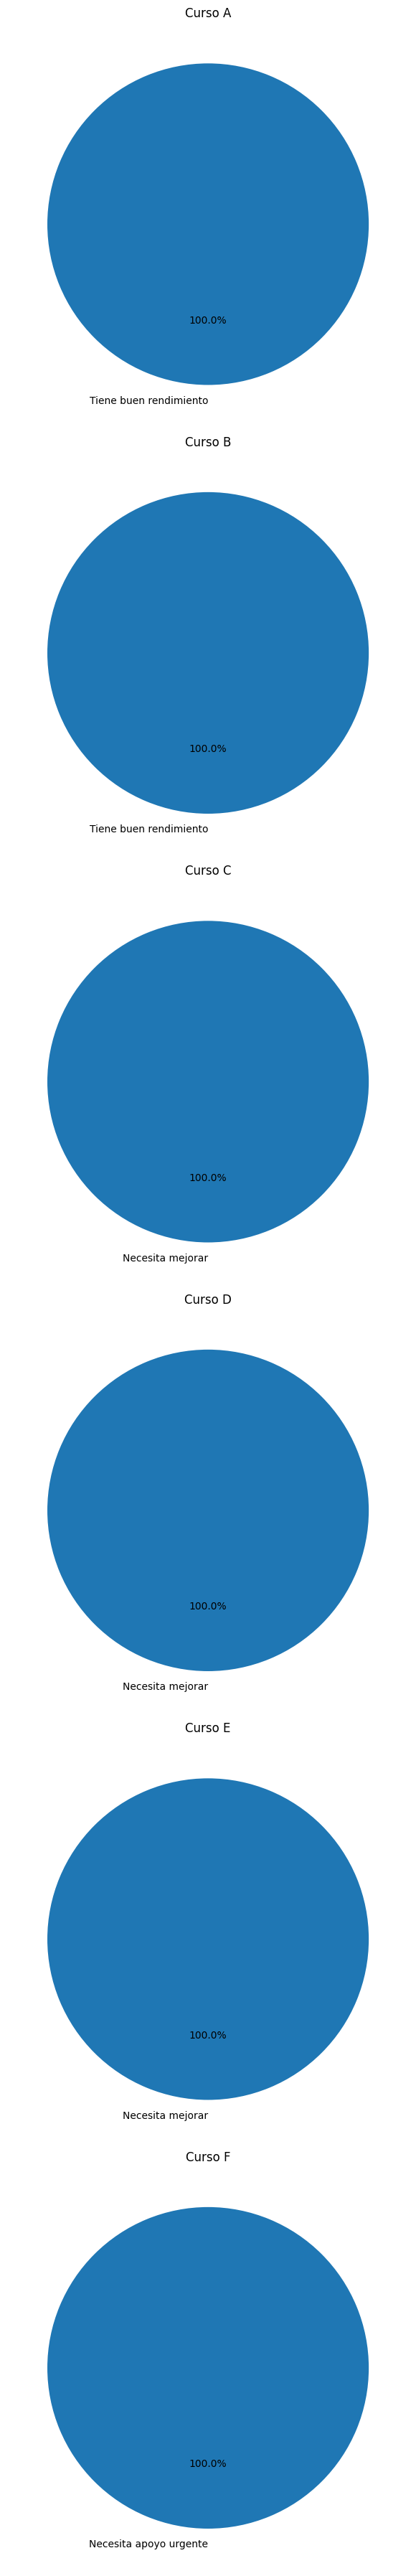

In [80]:
limites_categorias = [0, 10, 14, 18, 20]
etiquetas_categorias = ['Necesita apoyo urgente', 'Necesita mejorar', 'Necesita mejorar detalles', 'Tiene buen rendimiento']
datos_categorias_por_curso = []

for curso in df_predicciones.columns:
    notas = df_predicciones[curso]
    categorias = pd.cut(notas, bins=limites_categorias, labels=etiquetas_categorias)
    datos_categorias = categorias.value_counts()
    datos_categorias_por_curso.append(datos_categorias)

datos_categorias_por_curso_filtrados = [datos[datos > 0] for datos in datos_categorias_por_curso]

if len(datos_categorias_por_curso_filtrados) == 0:
    print("No hay datos de categorías válidos para mostrar.")
else:
    fig, axes = plt.subplots(nrows=len(datos_categorias_por_curso_filtrados), figsize=(8, 6*len(datos_categorias_por_curso_filtrados)))

    for i, (curso, datos_categorias) in enumerate(zip(df_predicciones.columns, datos_categorias_por_curso_filtrados)):
        ax = axes[i]
        ax.pie(datos_categorias, labels=datos_categorias.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(curso)

    plt.tight_layout()
    plt.show()

##Exportar Resultados

In [81]:
import xlsxwriter

output_file = "resultados.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_predicciones.to_excel(writer, sheet_name="Predicciones", index=False)
    df_predicciones_categorias.to_excel(writer, sheet_name="Mejoras", index=False)

    workbook = writer.book
    worksheet_predicciones = writer.sheets["Predicciones"]

    for i, col in enumerate(df_predicciones.columns):
        column_width = max(df_predicciones[col].astype(str).map(len).max(), len(col)) + 2
        worksheet_predicciones.set_column(i, i, column_width)

    worksheet_predicciones_cat = writer.sheets["Mejoras"]
    for i, col in enumerate(df_predicciones_categorias.columns):
        column_width = max(df_predicciones_categorias[col].astype(str).map(len).max(), len(col)) + 2
        worksheet_predicciones_cat.set_column(i, i, column_width)


files.download(output_file)

NameError: name 'files' is not defined